In [2]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import lzma
import numpy as np
import matplotlib.pyplot as plt
import random
import json
from torch.utils.data import TensorDataset, DataLoader
import itertools

In [17]:
from utils.model import deviceof, set_lr_on_step
from utils.env import State, Action, Transition, state_batch_to_tensor, action_batch_to_tensor, obs_batch_to_tensor, transition_json_to_batch, transition_batch_to_json

In [5]:
# load data
with lzma.open("../../data/mm_data_2.json.xz", "rb") as f:
    transition_data = transition_json_to_batch(json.load(f))

In [6]:
# save data
with lzma.open("./data/transition_data.json.xz", "wt") as f:
    json.dump(transition_batch_to_json(transition_data), f)

In [12]:
# 90:10 train-validation split
transition_train_data = transition_data[:int(len(transition_data)*0.9)]
transition_validation_data = transition_data[int(len(transition_data)*0.9):]

In [13]:
print("train data size:", len(transition_train_data))
print("validation data size:", len(transition_validation_data))

train data size: 450000
validation data size: 50000


In [10]:
# create a model that attempts to predict the next state given the current state and the action: (throttle and steering)
# each state contains: velocity_x, velocity_y, and heading
# creates a model that attempts to predict the action given the current state and the next state
class InverseDynamicsModel(nn.Module):
    def __init__(self):
        super().__init__()
        # input shape: (batch_size, 4, 2)
        # output shape: (batch_size, 2)

        self.conv1 = nn.Conv1d(4, 2048, 2) # Bx4x2 -> Bx768x1
        self.fc1 = nn.Linear(2048, 1536) # Bx768 -> Bx768
        self.fc2 = nn.Linear(1536, 1024) # Bx768 -> Bx768
        self.fc3 = nn.Linear(1024, 768) # Bx768 -> Bx768
        self.fc4 = nn.Linear(768, 2) # Bx768 -> Bx2
    
    def forward(self, x: torch.Tensor):
        x = F.relu(self.conv1(x))
        x = torch.flatten(x, 1)        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = torch.clamp(x, -1, 1)
        return x

def idm_train_batch(
        idm: InverseDynamicsModel,
        idm_optimizer: torch.optim.Optimizer,
        obs_tensor: torch.Tensor,
        a_tensor: torch.Tensor,
) -> float:
    device = deviceof(idm)

    obs_tensor = obs_tensor.to(device)
    a_tensor = a_tensor.to(device)

    idm_optimizer.zero_grad()

    pred_action = idm(obs_tensor)

    loss = F.mse_loss(pred_action, a_tensor)
    loss.backward()

    idm_optimizer.step()

    return float(loss.item())

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
idm_train_dataset = TensorDataset(
    obs_batch_to_tensor([(t.state, t.next_state) for t in transition_train_data], torch.device("cpu")),
    action_batch_to_tensor([t.action for t in transition_train_data], torch.device("cpu")),
)
idm_train_loader = DataLoader(idm_train_dataset, batch_size=8192, shuffle=True)
idm_train_iter = itertools.cycle(iter(idm_train_loader))

idm = InverseDynamicsModel().to(device)

idm_optimizer = torch.optim.AdamW(idm.parameters(), lr=0.0)

idm_step = 0
idm_losses = []

In [37]:
LR_SCHEDULE = {
    0: 1e-3,
    20_000: 5e-4,
    40_000: 2e-4,
    50_000: 1e-4,
    60_000: 5e-5,
    70_000: 2e-5,
    80_000: 1e-5,
}
INVERSE_DYNAMICS_MODEL_TRAIN_EPOCHS = 100_000

while idm_step < INVERSE_DYNAMICS_MODEL_TRAIN_EPOCHS:
    set_lr_on_step(idm_step, idm_optimizer, LR_SCHEDULE)
    obs_tensor, a_tensor = next(idm_train_iter) 
    loss = idm_train_batch(
        idm,
        idm_optimizer,
        obs_tensor,
        a_tensor,
    )
    idm_losses.append(loss)
    idm_step += 1
    if idm_step % 1000 == 0:
        # print average loss over last 100 steps
        loss = np.mean(idm_losses[-1000:])
        print(f"Step: {idm_step}, Loss: {loss:.6f}")

Set learning rate to 0.001 on step 0
Step: 1000, Loss: 0.071581
Step: 2000, Loss: 0.038107
Step: 3000, Loss: 0.026069
Step: 4000, Loss: 0.020572
Step: 5000, Loss: 0.016328
Step: 6000, Loss: 0.013353
Step: 7000, Loss: 0.010989
Step: 8000, Loss: 0.009414
Step: 9000, Loss: 0.007927
Step: 10000, Loss: 0.006733
Step: 11000, Loss: 0.006119
Step: 12000, Loss: 0.005400
Step: 13000, Loss: 0.005343
Step: 14000, Loss: 0.004509
Step: 15000, Loss: 0.004149
Step: 16000, Loss: 0.004241
Step: 17000, Loss: 0.003577
Step: 18000, Loss: 0.003729


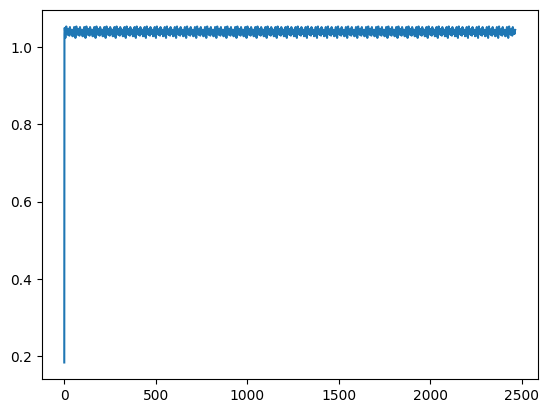

In [30]:
import matplotlib.pyplot as plt

# Plot the losses over training
plt.plot(list(range(len(idm_losses))), idm_losses, label='IDM')
plt.show()

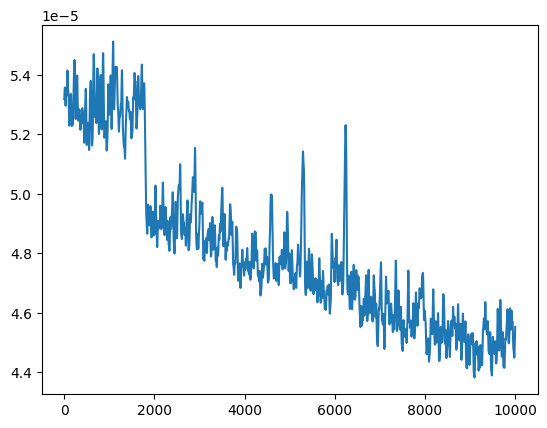

In [34]:
from scipy.ndimage import gaussian_filter1d

# plot the average reward per episode
idm_losses_averaged = gaussian_filter1d(idm_losses[-10000:], sigma=10)
plt.plot(idm_losses_averaged)

In [35]:
obs_tensor = obs_batch_to_tensor([(s0, s1) for s0, _, s1 in mm_train_data], device)
a_tensor = action_batch_to_tensor([a for _, a, _ in mm_train_data], device)

with torch.no_grad():
    a_pred_tensor = idm(obs_tensor)

loss = (a_tensor - a_pred_tensor)**2
loss_steer = loss[:, 0].cpu().detach().numpy()
loss_throttle = loss[:, 1].cpu().detach().numpy()

print("training loss", loss.mean().item())

training loss 0.0002885430585592985


In [36]:
obs_tensor = obs_batch_to_tensor([(s0, s1) for s0, _, s1 in mm_validation_data], device)
a_tensor = action_batch_to_tensor([a for _, a, _ in mm_validation_data], device)

with torch.no_grad():
    a_pred_tensor = idm(obs_tensor)

loss = (a_tensor - a_pred_tensor)**2
loss_steer = loss[:, 0].cpu().detach().numpy()
loss_throttle = loss[:, 1].cpu().detach().numpy()

print("validation loss", loss.mean().item())

validation loss 5.490003604791127e-05


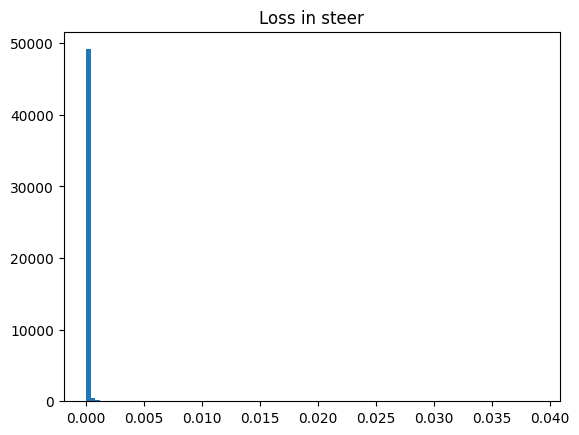

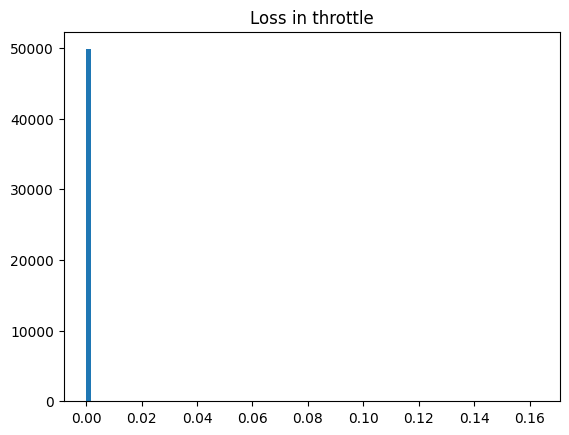

In [37]:
plt.hist(loss_steer, bins=100)
plt.title('Loss in steer')
plt.show()
plt.hist(loss_throttle, bins=100)
plt.title('Loss in throttle')
plt.show()